Mounted at /content/drive
Number of training images: 417
Number of validation images: 47
Number of testing images: 117


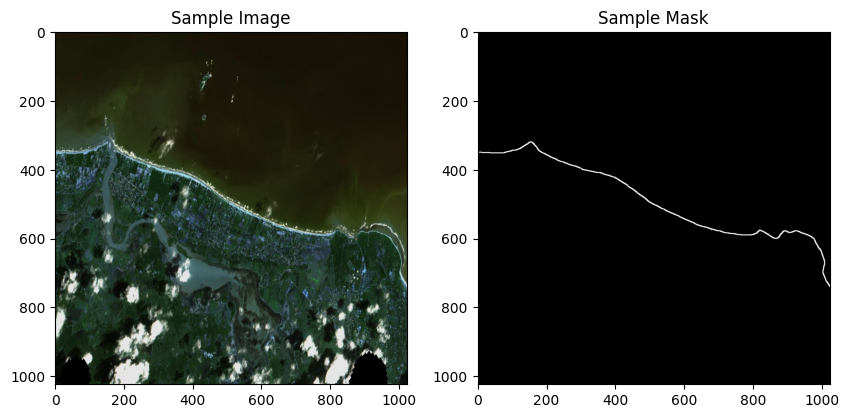

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Function to filter matching image and mask files
def filter_files(image_folder, mask_folder):
    image_files = sorted(os.listdir(image_folder))
    mask_files = sorted(os.listdir(mask_folder))

    valid_image_files = []
    valid_mask_files = []

    for img_file in image_files:
        if img_file.endswith('.jpg'):
            mask_file = img_file.replace('.jpg', '.png')
            if mask_file in mask_files:
                valid_image_files.append(img_file)
                valid_mask_files.append(mask_file)

    return valid_image_files, valid_mask_files

# Custom data generator
class ImageMaskGenerator(Sequence):
    def __init__(self, image_folder, mask_folder, image_files, mask_files, batch_size, crop_size=1024, shuffle=True):
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.image_files = image_files
        self.mask_files = mask_files
        self.batch_size = batch_size
        self.crop_size = crop_size
        self.shuffle = shuffle

    def __len__(self):
        return int(np.floor(len(self.image_files) / self.batch_size))

    def __getitem__(self, index):
        batch_image_files = self.image_files[index * self.batch_size:(index + 1) * self.batch_size]
        batch_mask_files = self.mask_files[index * self.batch_size:(index + 1) * self.batch_size]

        batch_images = []
        batch_masks = []

        for img_file, mask_file in zip(batch_image_files, batch_mask_files):
            img_path = os.path.join(self.image_folder, img_file)
            mask_path = os.path.join(self.mask_folder, mask_file)

            image = cv2.imread(img_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            if image is None:
                print(f"Error reading image: {img_file}")
                continue
            if mask is None:
                print(f"Error reading mask: {mask_file}")
                continue

            h, w, _ = image.shape
            mh, mw = mask.shape

            # Padding smaller images/masks to the required size
            if h < self.crop_size or w < self.crop_size:
                pad_h = self.crop_size - h if h < self.crop_size else 0
                pad_w = self.crop_size - w if w < self.crop_size else 0
                image = cv2.copyMakeBorder(image, 0, pad_h, 0, pad_w, cv2.BORDER_CONSTANT, value=0)

            if mh < self.crop_size or mw < self.crop_size:
                pad_mh = self.crop_size - mh if mh < self.crop_size else 0
                pad_mw = self.crop_size - mw if mw < self.crop_size else 0
                mask = cv2.copyMakeBorder(mask, 0, pad_mh, 0, pad_mw, cv2.BORDER_CONSTANT, value=0)

            # Center crop for image and mask
            start_x = w // 2 - self.crop_size // 2
            start_y = h // 2 - self.crop_size // 2
            image = image[start_y:start_y + self.crop_size, start_x:start_x + self.crop_size]

            start_x_m = mw // 2 - self.crop_size // 2
            start_y_m = mh // 2 - self.crop_size // 2
            mask = mask[start_y_m:start_y_m + self.crop_size, start_x_m:start_x_m + self.crop_size]

            batch_images.append(image)
            batch_masks.append(mask)

        # Convert to NumPy arrays and normalize
        batch_images = np.array(batch_images, dtype=np.float32) / 255.0
        batch_masks = np.expand_dims(np.array(batch_masks, dtype=np.float32), axis=-1)

        return batch_images, batch_masks

    def on_epoch_end(self):
        if self.shuffle:
            temp = list(zip(self.image_files, self.mask_files))
            np.random.shuffle(temp)
            self.image_files, self.mask_files = zip(*temp)

# Define dataset paths
image_folder = "/content/drive/My Drive/DSGP_Ravisha/Final Dataset/Sattelite images/"
mask_folder = "/content/drive/My Drive/DSGP_Ravisha/Final Dataset/png/EPR/"

# Match and filter valid pairs
image_files, mask_files = filter_files(image_folder, mask_folder)

# Train/val/test split
train_image_files, test_image_files, train_mask_files, test_mask_files = train_test_split(
    image_files, mask_files, test_size=0.2, random_state=42)

train_image_files, val_image_files, train_mask_files, val_mask_files = train_test_split(
    train_image_files, train_mask_files, test_size=0.1, random_state=42)

print(f"Number of training images: {len(train_image_files)}")
print(f"Number of validation images: {len(val_image_files)}")
print(f"Number of testing images: {len(test_image_files)}")

# Create data generators
train_gen = ImageMaskGenerator(image_folder, mask_folder, train_image_files, train_mask_files, batch_size=2)
val_gen = ImageMaskGenerator(image_folder, mask_folder, val_image_files, val_mask_files, batch_size=2)
test_gen = ImageMaskGenerator(image_folder, mask_folder, test_image_files, test_mask_files, batch_size=2)

# Visualize a sample image and mask
batch_images, batch_masks = train_gen[0]
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(batch_images[0])
plt.title("Sample Image")
plt.subplot(1, 2, 2)
plt.imshow(batch_masks[0].squeeze(), cmap='gray')
plt.title("Sample Mask")
plt.show()


In [2]:
print("Image batch shape:", batch_images.shape)
print("Mask batch shape:", batch_masks.shape)
print("Single image shape:", batch_images[0].shape)
print("Single mask shape:", batch_masks[0].shape)


Image batch shape: (2, 1024, 1024, 3)
Mask batch shape: (2, 1024, 1024, 1)
Single image shape: (1024, 1024, 3)
Single mask shape: (1024, 1024, 1)


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

def create_segnet_model(input_shape=(1024, 1024, 3)):
    """SegNet model with 1024x1024 input/output and no shape mismatches."""
    model = models.Sequential()

    # --- Encoder (Downsampling) ---
    # Block 1 (1024 -> 512)
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2), padding='same'))  # 1024x1024 -> 512x512

    # Block 2 (512 -> 256)
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2), padding='same'))  # 512x512 -> 256x256

    # Block 3 (256 -> 128)
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2), padding='same'))  # 256x256 -> 128x128

    # Block 4 (128 -> 64)
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2), padding='same'))  # 128x128 -> 64x64

    # --- Decoder (Upsampling) ---
    # Block 5 (64 -> 128)
    model.add(layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())

    # Block 6 (128 -> 256)
    model.add(layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())

    # Block 7 (256 -> 512)
    model.add(layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())

    # Block 8 (512 -> 1024)
    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())

    # Output layer
    model.add(layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same'))  # 1024x1024x1

    return model

# ===== Loss Functions =====
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
    cross_entropy = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
    loss = alpha * tf.pow(1 - y_pred, gamma) * cross_entropy
    return tf.reduce_mean(loss)

def combined_loss(y_true, y_pred):
    return dice_loss(y_true, y_pred) + 0.5 * focal_loss(y_true, y_pred)

# ===== Model Compilation =====
model = create_segnet_model(input_shape=(1024, 1024, 3))
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss=combined_loss,  # Can use dice_loss, focal_loss, or combined_loss
    metrics=['accuracy', tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])]
)

# ===== Verification =====
print("Input shape:", model.input_shape)   # (None, 1024, 1024, 3)
print("Output shape:", model.output_shape) # (None, 1024, 1024, 1) ✅

# ===== Model Summary =====
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Input shape: (None, 1024, 1024, 3)
Output shape: (None, 1024, 1024, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 1024, 1024, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024, 1024, 64)      │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 512, 512, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 512, 512, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512, 512, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 256, 256, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 256, 256, 256)       │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256, 256, 256)       │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 128, 128, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 512)       │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128, 128, 512)       │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 64, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 128, 128, 512)       │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128, 128, 512)       │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 256, 256, 256)       │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 256, 256, 256)       │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 512, 512, 128)       │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 512, 512, 128)       │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 5,467,265 (20.86 MB)

 Trainable params: 5,463,425 (20.84 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [ ]:
# Check the number of batches in the generator
print(f"Number of batches in train_gen: {len(train_gen)}")
print(f"Number of batches in val_gen: {len(val_gen)}")

# Print the first batch of images and masks to verify their shapes
batch_images, batch_masks = train_gen[0]
print(f"Batch images shape: {batch_images.shape}")
print(f"Batch masks shape: {batch_masks.shape}")

# Fit the model with appropriate steps
history = model.fit(
    train_gen,                # The training data generator
    epochs=100,                 # Train for just 1 epoch to debug
    validation_data=val_gen,  # The validation data generator
    steps_per_epoch=len(train_gen),  # Set steps per epoch based on the generator length
    validation_steps=len(val_gen),  # Set validation steps based on the generator length
)


Number of batches in train_gen: 208
Number of batches in val_gen: 23
Batch images shape: (2, 1024, 1024, 3)
Batch masks shape: (2, 1024, 1024, 1)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 273s 1s/step - accuracy: 0.8008 - io_u: 2.9619e-07 - loss: -0.6527 - val_accuracy: 0.7159 - val_io_u: 0.0000e+00 - val_loss: 1.0546
Epoch 2/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 105s 506ms/step - accuracy: 0.8965 - io_u: 9.7787e-08 - loss: -0.8039 - val_accuracy: 0.9936 - val_io_u: 0.0000e+00 - val_loss: 1.9595
Epoch 3/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 143s 509ms/step - accuracy: 0.9318 - io_u: 1.8893e-07 - loss: -0.8632 - val_accuracy: 0.9711 - val_io_u: 0.0000e+00 - val_loss: -0.4735
Epoch 4/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 142s 509ms/step - accuracy: 0.9385 - io_u: 5.5132e-08 - loss: -0.8755 - val_accuracy: 0.9658 - val_io_u: 0.0000e+00 - val_loss: -0.8363
Epoch 5/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 105s 506ms/step - accuracy: 0.9524 - io_u: 1.7898e-07 - loss: -0.9061 - val_accuracy: 0.9715 - val_io_u: 0.0000e+00 - val_loss: -0.6875
Epoch 6/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 142s 508ms/step - accuracy: 0.9483 - io_u: 3.9319e-07 - loss: -0.8996 - val_acc

In [ ]:
# Save the trained model to Google Drive
model.save('/content/drive/MyDrive/DSGP_Ravisha/segnet_model.h5')  # Update the path if needed
print("Model saved successfully!")

Model saved successfully!


In [4]:
import os
# Mount Google Drive (if running on Google Colab)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

model_path = "/content/drive/My Drive/DSGP_Ravisha/segnet_model.h5"

if os.path.exists(model_path):
    print("File exists!")
else:
    print("File not found. Check the path.")

Mounted at /content/drive
File exists!


In [5]:
import tensorflow.keras.backend as K

def dice_coefficient(y_true, y_pred):
    """
    Calculates the Dice coefficient for binary segmentation.
    """
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2 * intersection) / (union + K.epsilon())


In [8]:
from tensorflow.keras.models import load_model
model = load_model(model_path, custom_objects={'dice_coefficient': dice_coefficient}, compile=False)


In [ ]:
# Save the trained model to Google Drive
model.save('/content/drive/MyDrive/DSGP_Ravisha/segnet_modelwithdice.h5')  # Update the path if needed
print("Model saved successfully!")

Model saved successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


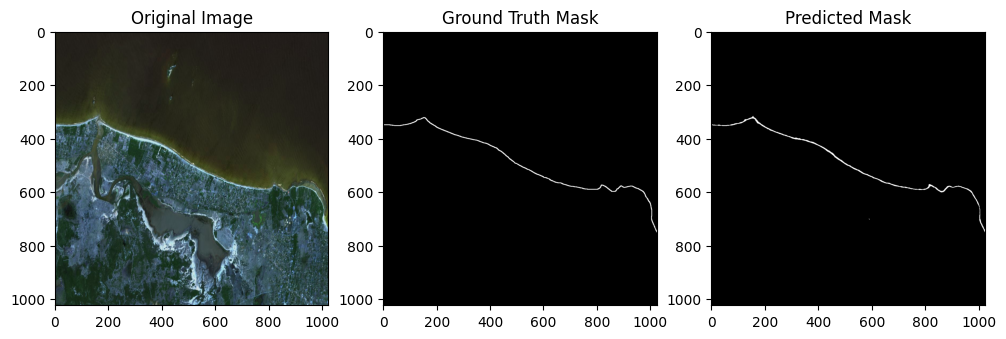

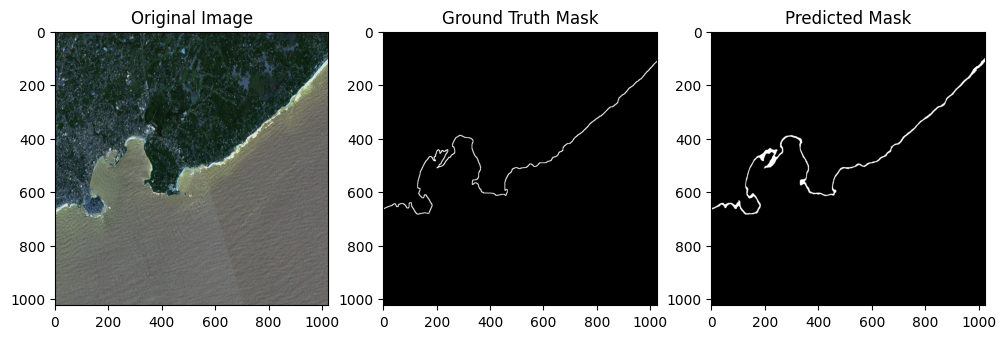

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import erosion, disk

# Select a sample batch from the test set
batch_images, batch_masks = test_gen[3]  # Get first batch
batch_size = batch_images.shape[0]  # Get the actual batch size

# Predict masks using the trained model
predicted_masks = model.predict(batch_images)

# Convert predicted masks to binary (if they are not already)
predicted_masks_binary = (predicted_masks > 0.5).astype(np.uint8)  # Threshold the predictions to binary

# Apply morphological erosion to reduce shoreline thickness (adjust erosion radius)
erosion_radius = 2  # Adjust this value for desired effect
predicted_masks_erosion = np.array([erosion(mask.squeeze(), disk(erosion_radius)) for mask in predicted_masks_binary])

# Visualize the results
for i in range(batch_size):
    plt.figure(figsize=(12, 4))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(batch_images[i])
    plt.title("Original Image")

    # Ground Truth Mask
    plt.subplot(1, 3, 2)
    plt.imshow(batch_masks[i].squeeze(), cmap="gray")
    plt.title("Ground Truth Mask")

    # Predicted Mask (after thresholding and erosion)
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_masks_erosion[i].squeeze(), cmap="gray")
    plt.title("Predicted Mask")

    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


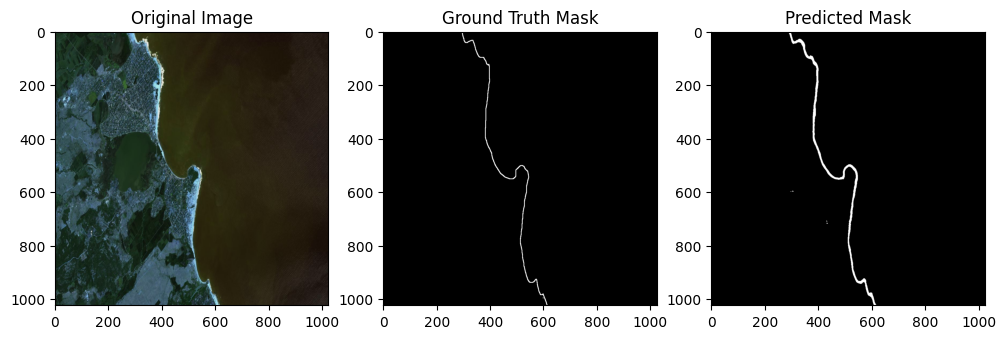

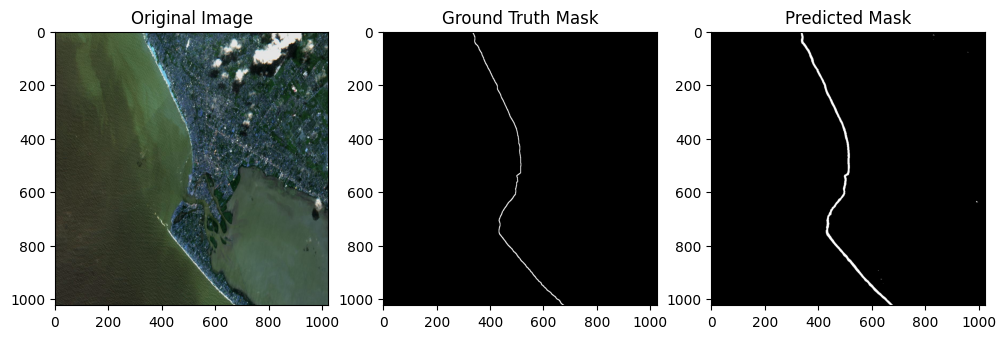

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Select a sample batch from the test set
batch_images, batch_masks = test_gen[4]  # Get 5th batch
batch_size = batch_images.shape[0]  # Actual batch size

# Predict masks using the trained model
predicted_masks = model.predict(batch_images)

# Convert predictions to binary masks using threshold
predicted_masks_binary = (predicted_masks > 0.5).astype(np.uint8)

# Visualize results
for i in range(batch_size):
    plt.figure(figsize=(12, 4))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(batch_images[i])
    plt.title("Original Image")

    # Ground Truth Mask
    plt.subplot(1, 3, 2)
    plt.imshow(batch_masks[i].squeeze(), cmap="gray")
    plt.title("Ground Truth Mask")

    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_masks_binary[i].squeeze(), cmap="gray")
    plt.title("Predicted Mask")

    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
Classification Report:
               precision    recall  f1-score   support

  Background       1.00      0.99      1.00   2087459
   Shoreline       0.44      0.98      0.60      9693

    accuracy                           0.99   2097152
   macro avg       0.72      0.99      0.80   2097152
weighted avg       1.00      0.99      1.00   2097152

Confusion Matrix:
 [[2075112   12347]
 [    165    9528]]


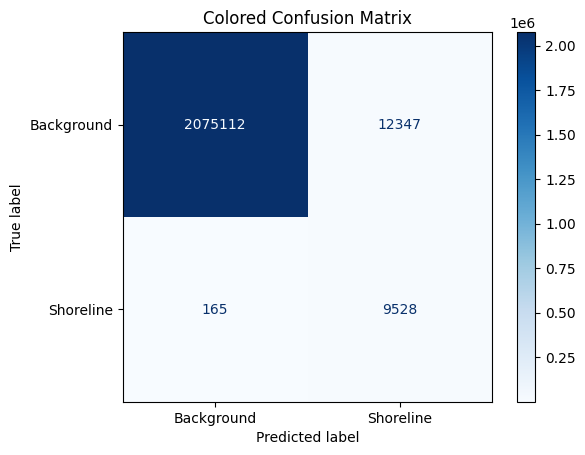

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Get a batch of validation data
val_images, val_masks = val_gen[0]

# Predict masks for the batch
pred_masks = model.predict(val_images)

# Binarize predictions and masks
pred_masks_bin = (pred_masks > 0.5).astype(np.uint8)
val_masks_bin = (val_masks > 0.5).astype(np.uint8)

# Flatten arrays to 1D
y_true_flat = val_masks_bin.flatten()
y_pred_flat = pred_masks_bin.flatten()

# Classification report
report = classification_report(y_true_flat, y_pred_flat, target_names=['Background', 'Shoreline'])
print("Classification Report:\n", report)

# Optional: Confusion Matrix
cm = confusion_matrix(y_true_flat, y_pred_flat)
print("Confusion Matrix:\n", cm)


# Display the confusion matrix with colors
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Background", "Shoreline"])
disp.plot(cmap=plt.cm.Blues, values_format='d')  # 'd' = integer formatting

plt.title("Colored Confusion Matrix")
plt.show()

